In [1]:
#%reload_ext signature
%matplotlib inline

import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

In [2]:
Pre = 1
if Pre == 1:
    data_path = "/home/ef2p/Kaggle/cardiac/PreTx_12_08_2016/"
    x0, y0, w, n = 250, 280, 25, 0
else:
    data_path = "/home/ef2p/Kaggle/cardiac/PostTx_3_17_2017/"
    x0, y0, w, n = 260, 270, 25, 40

output_path = working_path = "/home/ef2p/Kaggle/cardiac/Documents/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print ('\n'.join(g[:5]))

Total of 104 DICOM images.
First 5 filenames:
/home/ef2p/Kaggle/cardiac/PreTx_12_08_2016/CT1.2.840.113704.1.111.3004.1481211261.608.dcm
/home/ef2p/Kaggle/cardiac/PreTx_12_08_2016/CT1.2.840.113704.1.111.3004.1481211301.652.dcm
/home/ef2p/Kaggle/cardiac/PreTx_12_08_2016/CT1.2.840.113704.1.111.3004.1481211285.634.dcm
/home/ef2p/Kaggle/cardiac/PreTx_12_08_2016/CT1.2.840.113704.1.111.3004.1481211337.692.dcm
/home/ef2p/Kaggle/cardiac/PreTx_12_08_2016/CT1.2.840.113704.1.111.3004.1481211268.616.dcm


In [3]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope

    # EF
    #print(intercept, slope)

    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
      # EF set blood 30<HU<70 to 1, everything else to zero
    image[image > 60] = 0
    image[image < 10] = 0
    image[ image!= 0 ] = 1
    image = 1 - image # flip white <--> black
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

In [4]:
if Pre == 0:
    np.save(output_path + "post-images.npy", imgs[:,x0-w:x0+w,y0-w:y0+w])
else:
     np.save(output_path + "pre-images.npy", imgs[:,x0-w:x0+w,y0-w:y0+w])
        
#np.save(output_path + "fullimages_%d.npy" % (id), imgs[:,x0-w:x0+w,y0-w:y0+w])
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

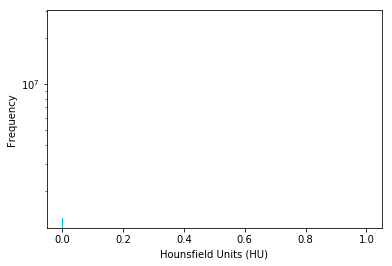

In [ ]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=500, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()


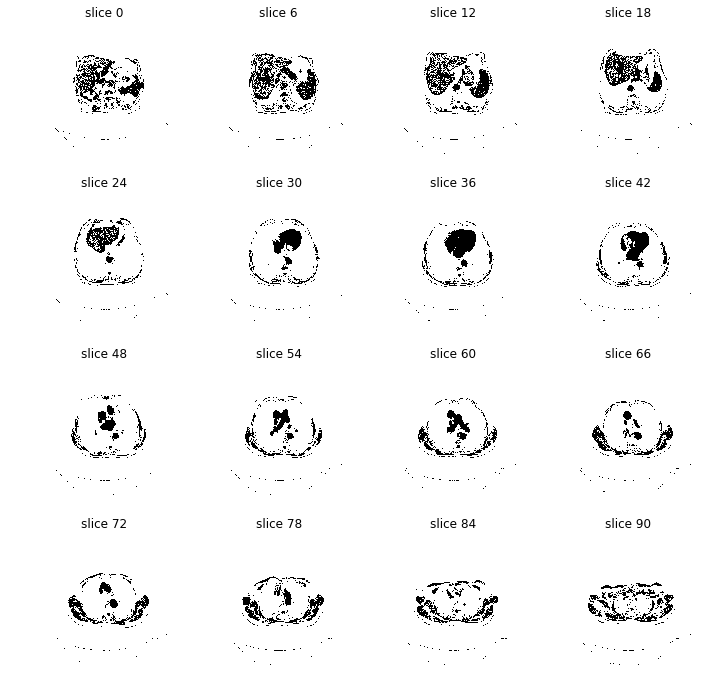

(104, 512, 512)


In [ ]:
d = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=4, cols=4, start_with=n, show_every=6):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.savefig('ct.png', bbox_inches='tight')
    plt.show()

sample_stack(imgs_to_process)
print(imgs.shape)


In [ ]:
print ("Slice Thickness: %f" % patient[0].SliceThickness)
print ("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))
       

Slice Thickness: 3.000000
Pixel Spacing (row, col): (1.171875, 1.171875) 


In [ ]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
 #   spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
 # EF stack overflow coreection for pydicom 1.0.2
    spacing = map(float, ([scan[0].SliceThickness, scan[0].PixelSpacing[0], scan[0].PixelSpacing[1]]))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print ("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])

#imgs_after_resamp = imgs_after_resamp[:,200:400,200:400]

print ("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (104, 512, 512)
Shape after resampling	 (312, 600, 600)


In [ ]:
#def make_mesh(image, threshold=-300, step_size=1):
# EF
def make_mesh(image, threshold=1, step_size=1):
    
    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    # EF stackoverflow, new version of marching cubes
    #verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)   
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print ("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    #ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    ax.set_facecolor((0.7, 0.7, 0.7)) 
    plt.show()


In [ ]:
#v, f = make_mesh(imgs_after_resamp, 350)
v, f = make_mesh(imgs_after_resamp, 0.5) # change THR, notice that we set img = 1!
plt_3d(v, f)

Transposing surface
Calculating surface
Drawing


In [ ]:
#v, f = make_mesh(imgs_after_resamp, 350, 2)
v, f = make_mesh(imgs_after_resamp, 0.5, 2) #  change THR, notice that img = 1
plotly_3d(v, f)

In [ ]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
# EF
    print(centers, threshold)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[20, 20])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

In [ ]:
img = imgs_after_resamp[260]
make_lungmask(img, display=True)                     
                        

In [ ]:
masked_lung = []

for img in imgs_after_resamp:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=10)

In [ ]:
np.save(output_path + "maskedimages_%d.npy" % (id), imgs)